In [5]:
library(tidyverse)
library(mgsub)
library(igraph)
library(ggraph)

In [2]:
cluster_results <- read.csv('mosuo_5c_3k.csv',row.names=1)
# Relationship labels that are more concise
mapping = read.csv('rels_simple.csv')
colnames(mapping) = c('origin','simple')
rownames(cluster_results) = mgsub(rownames(cluster_results),
                                  mapping$'origin',mapping$'simple')
rownames(cluster_results) = mapping$'simple'
cluster_k3 = as.matrix(cluster_results['cl_k3'])
cluster_k3 = data.frame(cluster_k3[order(cluster_k3[,1]),])
colnames(cluster_k3) =c('cl_k3')

Private = rownames(cluster_k3 %>% filter(cl_k3==0))
Public = rownames(cluster_k3 %>% filter(cl_k3==1))
Hostile = rownames(cluster_k3 %>% filter(cl_k3==2))

cluster_k3 = cluster_k3 %>% mutate(cluster = 
                        case_when(cl_k3==0~'Public',
                                  cl_k3==1~'Private',
                                  cl_k3==2~'Hostile'))

In [3]:
# create a data frame giving the hierarchical structure of your individuals
d1=data.frame(from="Total", to=c('Public','Private','Hostile'))
d2=data.frame(from=c(cluster_k3$'cluster'),to=c(Public,Private,Hostile))
edges=rbind(d1, d2)

# create a vertices data.frame. One line per object of our hierarchy
vertices = data.frame(
  name = unique(c(as.character(edges$from), as.character(edges$to))) , 
  value = runif(79)
) 
# Let's add a column with the group of each name. It will be useful later to color points
vertices$group = edges$from[ match( vertices$name, edges$to ) ]

#Let's add information concerning the label we are going to add: angle, horizontal adjustement and potential flip
#calculate the ANGLE of the labels
vertices$id=NA
myleaves=which(is.na( match(vertices$name, edges$from) ))
nleaves=length(myleaves)
vertices$id[ myleaves ] = seq(1:nleaves)
vertices$angle= 90 - 360 * vertices$id / nleaves

# calculate the alignment of labels: right or left
# If I am on the left part of the plot, my labels have currently an angle < -90
vertices$hjust<-ifelse( vertices$angle < -90, 1, 0)

# flip angle BY to make them readable
vertices$angle<-ifelse(vertices$angle < -90, vertices$angle+180, vertices$angle)

# Create a graph object
mygraph <- graph_from_data_frame( edges, vertices=vertices )

my_colors = c('Hostile'='#52DCF5','Public'='#3FCA36','Private'='#FF4C27')

Warning message:
"Using the `size` aesthetic in this geom was deprecated in ggplot2 3.4.0.
i Please use `linewidth` in the `default_aes` field and elsewhere instead."


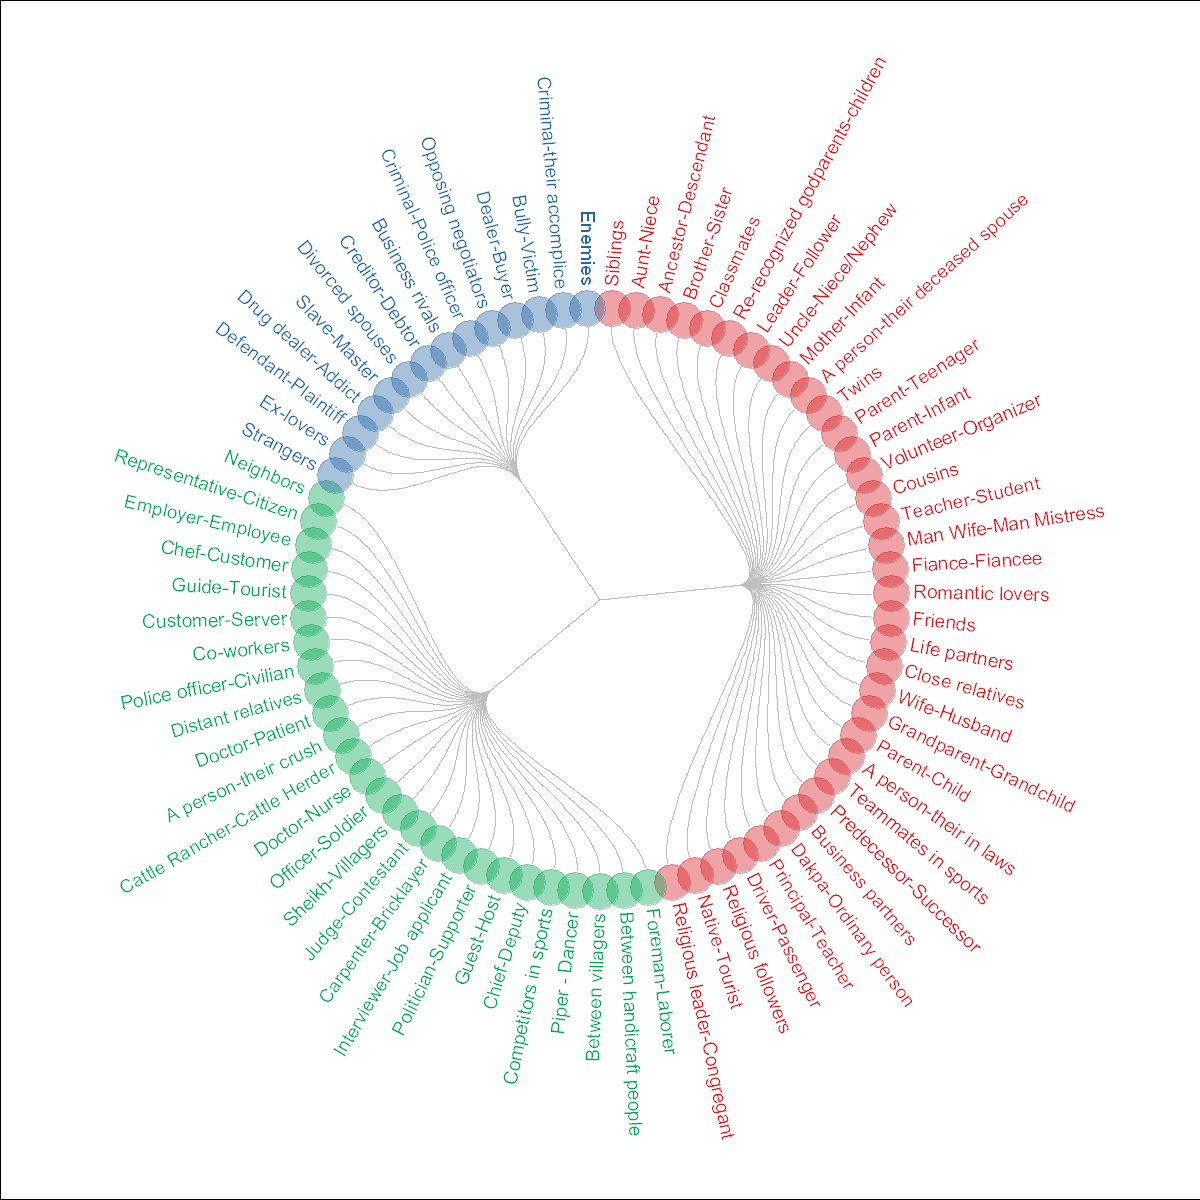

In [4]:
my_colors = c('Hostile'='#2466A2','Private'='#03A652','Public'='#D81920')
# Make the plot
options(repr.plot.width=10,repr.plot.height=10)
ggraph(mygraph, layout = 'dendrogram', circular = TRUE) + 
  geom_edge_diagonal(colour="grey") +
  #scale_edge_colour_distiller(palette = "RdPu") +
  scale_colour_manual(values=my_colors)+
   geom_node_text(aes(x = x*1.15, y=y*1.15, filter = leaf, 
                      label=name, angle = angle, hjust=hjust, colour=group),
                      size=4, alpha=1) +
  geom_node_point(aes(filter = leaf, x = x*1.07, y=y*1.07, 
                      colour=group), size=10, alpha=0.4) +
  theme_void() +
  theme(
    legend.position="none",
    plot.margin=unit(c(0,0,0,0),"cm"),
    panel.background = element_rect(fill='white')
  ) +
  expand_limits(x = c(-2, 2), y = c(-2, 2))